In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset (replace with your file path)
df = pd.read_csv('Telco-Customer-Churn.csv')

# Handle missing values in TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Drop irrelevant columns
df.drop('customerID', axis=1, inplace=True)

# Define categorical columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
multiclass_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaymentMethod']

# Label encode binary categorical columns
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode multi-class categorical columns
df = pd.get_dummies(df, columns=multiclass_cols, drop_first=True)

# Scale numerical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Encode target variable
df['Churn'] = le.fit_transform(df['Churn'])  # Yes/No → 1/0

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Verify all columns are numeric
print("Data types of features:")
print(X.dtypes)
print("\nFirst few rows of X:")
print(X.head())

# Check for any non-numeric values
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Non-numeric column found: {col}")
        print(X[col].unique())

Data types of features:
gender                                     int64
SeniorCitizen                              int64
Partner                                    int64
Dependents                                 int64
tenure                                   float64
PhoneService                               int64
PaperlessBilling                           int64
MonthlyCharges                           float64
TotalCharges                             float64
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
OnlineBackup_No internet service            bool
OnlineBackup_Yes                            bool
DeviceProtection_No internet service        bool
DeviceProtection_Yes                        bool
TechSupport_No internet service             b

/var/folders/d2/nq0x9cjd54q2hrh6rmmlh6780000gn/T/ipykernel_96775/3024992081.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Train the model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

Training set size: (5634, 30)
Test set size: (1409, 30)


Accuracy: 0.79


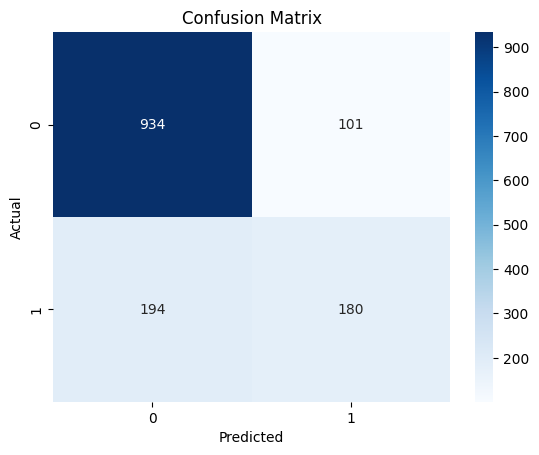

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

In [25]:
print("Confusion Matrix (flattened):", cm.flatten())

Confusion Matrix (flattened): [934 101 194 180]


In [26]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Retrain
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)

# Re-evaluate
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1035
           1       0.53      0.62      0.57       374

    accuracy                           0.75      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.75      0.76      1409



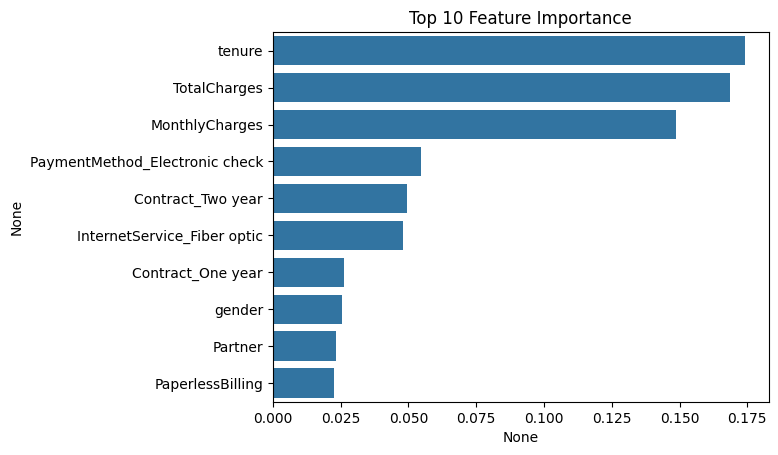

In [27]:
import pandas as pd
import seaborn as sns

# Feature importance
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot top 10
sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10])
plt.title('Top 10 Feature Importance')
plt.show()

In [28]:
import joblib

# Save model
joblib.dump(rf, 'churn_model.pkl')

# Test prediction
model = joblib.load('churn_model.pkl')
new_data = X_test.iloc[0:1]
prediction = model.predict(new_data)
print("Churn Prediction:", "Yes" if prediction[0] == 1 else "No")

Churn Prediction: No
